In [ ]:
# UNIT 2: Imports & helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.optimize import brentq
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# Physical constant
R = 8.31446261815324  # J/(mol K)

# Equilibrium function (regular solution / van't Hoff form)
# Solve for T (K) from: ln(x) + (DeltaH/R)*(1/T - 1/Tm) + (Omega/(R*T))*(1 - 2*x) = 0
def equilibrium_equation_T(T, x, DeltaH, Tm, Omega):
    # Avoid division by zero and extreme T
    return np.log(np.clip(x,1e-12,1.0)) + (DeltaH / R) * (1.0/T - 1.0/Tm) + (Omega / (R * T)) * (1.0 - 2.0*x)

# Robust wrapper to solve for T (returns NaN if no root found)
def solve_equilibrium_T_for_x(x, DeltaH, Tm, Omega, Tmin=200.0, Tmax_factor=1.02):
    # Tmin in K, Tmax slightly above Tm
    Tmax = Tm * Tmax_factor
    # Make sure f(Tmin) and f(Tmax) have opposite sign for brentq
    try:
        fmin = equilibrium_equation_T(Tmin, x, DeltaH, Tm, Omega)
        fmax = equilibrium_equation_T(Tmax, x, DeltaH, Tm, Omega)
        if np.isnan(fmin) or np.isnan(fmax):
            return np.nan
        # If same sign, try expanding Tmax
        if fmin * fmax > 0:
            Tmax2 = Tm * 1.5
            fmax2 = equilibrium_equation_T(Tmax2, x, DeltaH, Tm, Omega)
            if fmin * fmax2 > 0:
                return np.nan
            else:
                root = brentq(equilibrium_equation_T, Tmin, Tmax2, args=(x, DeltaH, Tm, Omega), maxiter=200)
                return root
        else:
            root = brentq(equilibrium_equation_T, Tmin, Tmax, args=(x, DeltaH, Tm, Omega), maxiter=200)
            return root
    except Exception:
        return np.nan


In [ ]:
# UNIT 3: Generate synthetic systems and compute equilibrium points
n_systems = 1000            # number of distinct binary systems
n_x = 20                    # number of composition points per system
compositions = np.linspace(0.01, 0.99, n_x)  # mole fraction of component A

rows = []
count_success = 0
count_total = n_systems * n_x

# Parameter sampling ranges (physically plausible variation)
# Temperatures in Kelvin; DeltaH in J/mol; Omega in J/mol (interaction parameter)
TmA_range = (900.0, 2000.0)           # melting point A (K)
TmB_range = (600.0, 2000.0)           # melting point B (K)
dH_A_range = (80000.0, 180000.0)      # Heat of fusion A (J/mol)
dH_B_range = (60000.0, 200000.0)      # Heat of fusion B (J/mol)
Omega_range = (-2e4, 8e4)             # interaction parameter (J/mol) -> negative -> ordering, positive -> tendency to phase separate

for i in tqdm(range(n_systems), desc="Generating systems"):
    # Randomly sample system parameters
    TmA = np.random.uniform(*TmA_range)
    TmB = np.random.uniform(*TmB_range)
    dH_A = np.random.uniform(*dH_A_range)
    dH_B = np.random.uniform(*dH_B_range)
    Omega = np.random.uniform(*Omega_range)
    # enforce TmA != TmB to get variety
    if abs(TmA - TmB) < 20:
        TmB += np.sign(np.random.randn()) * 50.0

    for x in compositions:
        # Solve for liquidus temperature from component A side (x_A = x)
        T_A = solve_equilibrium_T_for_x(x, dH_A, TmA, Omega)
        # Solve for liquidus temperature from component B side (x_B = 1-x)
        xB = 1.0 - x
        T_B = solve_equilibrium_T_for_x(xB, dH_B, TmB, Omega)

        # Heuristic: choose liquidus estimate as min(T_A, T_B) when both valid (physical)
        # If both NaN, record NaN (will be filtered later)
        if np.isfinite(T_A) and np.isfinite(T_B):
            T_liquidus = min(T_A, T_B)
        elif np.isfinite(T_A):
            T_liquidus = T_A
        elif np.isfinite(T_B):
            T_liquidus = T_B
        else:
            T_liquidus = np.nan

        rows.append({
            "system_id": i,
            "x_A": x,
            "TmA_K": TmA,
            "TmB_K": TmB,
            "dH_A_Jpermol": dH_A,
            "dH_B_Jpermol": dH_B,
            "Omega_Jpermol": Omega,
            "T_liquidus_K": T_liquidus
        })

df_phase = pd.DataFrame(rows)
print("Raw phase dataset rows:", len(df_phase))
# Filter out rows where solver failed
df_phase = df_phase[df_phase["T_liquidus_K"].notna()].reset_index(drop=True)
print("Usable rows after filtering solver failures:", len(df_phase))
# Show sample
df_phase.head()


Generating systems:   0%|          | 0/1000 [00:00<?, ?it/s]

Raw phase dataset rows: 20000
Usable rows after filtering solver failures: 20000


,system_id,x_A,TmA_K,TmB_K,dH_A_Jpermol,dH_B_Jpermol,Omega_Jpermol,T_liquidus_K
0,0,0.010000,1311.994131,1931.000029,153199.394181,143812.187788,-4398.135956,960.217126
1,0,0.061579,1311.994131,1931.000029,153199.394181,143812.187788,-4398.135956,1067.159139
2,0,0.113158,1311.994131,1931.000029,153199.394181,143812.187788,-4398.135956,1110.547965
3,0,0.164737,1311.994131,1931.000029,153199.394181,143812.187788,-4398.135956,1140.309987
4,0,0.216316,1311.994131,1931.000029,153199.394181,143812.187788,-4398.135956,1163.756307


In [ ]:
# UNIT 4: Dataset size & basic statistics
print("Total systems:", n_systems)
print("Requested rows (n_systems * n_x):", n_systems * n_x)
print("Usable rows:", df_phase.shape[0])
df_phase.describe().round(3)


Total systems: 1000
Requested rows (n_systems * n_x): 20000
Usable rows: 20000


,system_id,x_A,TmA_K,TmB_K,dH_A_Jpermol,dH_B_Jpermol,Omega_Jpermol,T_liquidus_K
count,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,499.500,0.500,1462.540,1279.711,130324.943,128664.494,29613.377,993.769
std,288.682,0.297,316.832,412.267,28827.650,40395.674,28687.765,295.387
min,0.000,0.010,900.148,600.016,80059.794,60189.508,-19934.661,200.998
25%,249.750,0.255,1184.108,918.930,104811.922,94411.851,4828.874,774.910
50%,499.500,0.500,1479.917,1275.755,130686.690,128061.290,30008.190,975.384
75%,749.250,0.745,1742.073,1632.561,154379.946,163057.171,54269.547,1198.948
max,999.000,0.990,1996.179,2030.695,179955.770,199605.530,79889.261,2213.460


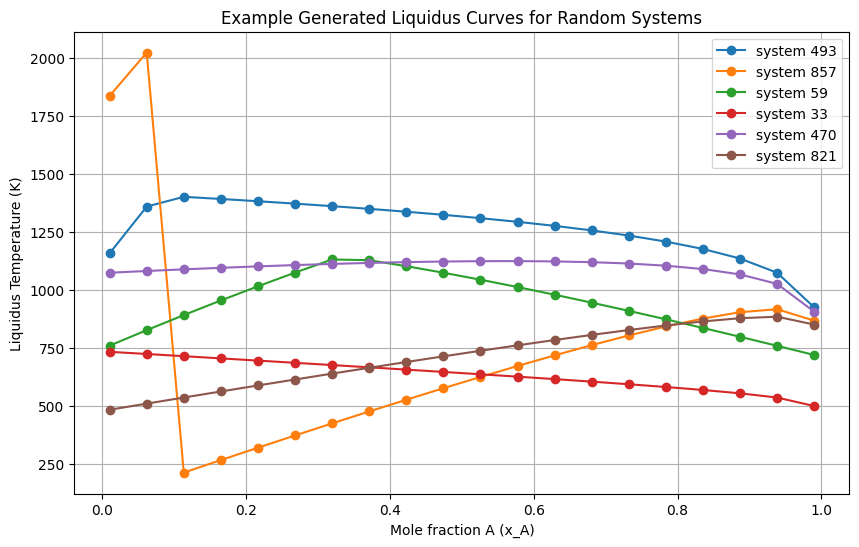

In [ ]:
# UNIT 5: Plot some example phase diagrams (composition vs liquidus T)
plt.figure(figsize=(10,6))
example_systems = np.random.choice(df_phase['system_id'].unique(), size=6, replace=False)
for sid in example_systems:
    sub = df_phase[df_phase['system_id']==sid].sort_values('x_A')
    plt.plot(sub['x_A'], sub['T_liquidus_K'], marker='o', label=f"system {sid}")
plt.xlabel("Mole fraction A (x_A)")
plt.ylabel("Liquidus Temperature (K)")
plt.title("Example Generated Liquidus Curves for Random Systems")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# UNIT 6: prepare data for ML surrogate model
# Features: composition x_A + system parameters
data = df_phase.copy()
# target: T_liquidus_K
X = data[["x_A","TmA_K","TmB_K","dH_A_Jpermol","dH_B_Jpermol","Omega_Jpermol"]].copy()
y = data["T_liquidus_K"].copy()

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 16400 Test size: 3600


In [ ]:
# UNIT 7: Train RandomForest surrogate
rf = RandomForestRegressor(n_estimators=300, max_depth=22, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# Predict & evaluate
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Surrogate RF -> MAE: {mae:.2f} K, RMSE: {rmse:.2f} K, R2: {r2:.4f}")


Surrogate RF -> MAE: 25.16 K, RMSE: 75.30 K, R2: 0.9332


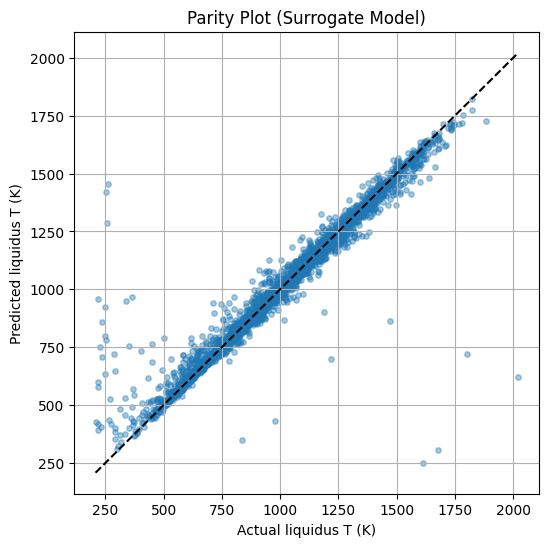

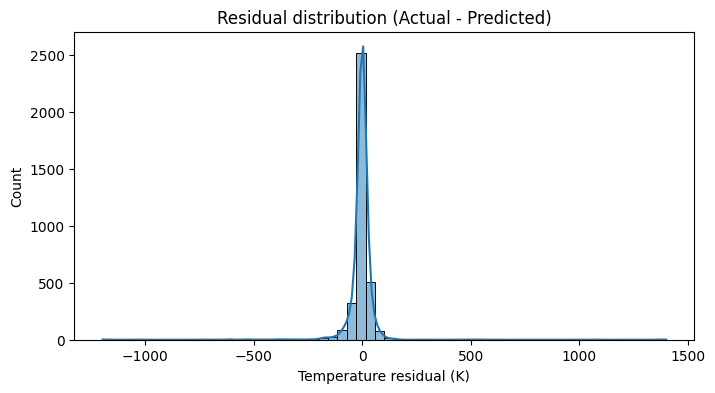

In [ ]:
# UNIT 8: Parity and residuals
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4, s=15)
mn = min(y_test.min(), y_pred.min())
mx = max(y_test.max(), y_pred.max())
plt.plot([mn,mx],[mn,mx],'k--')
plt.xlabel("Actual liquidus T (K)")
plt.ylabel("Predicted liquidus T (K)")
plt.title("Parity Plot (Surrogate Model)")
plt.grid(True)
plt.show()

# Residual histogram
resid = y_test - y_pred
plt.figure(figsize=(8,4))
sns.histplot(resid, kde=True, bins=60)
plt.title("Residual distribution (Actual - Predicted)")
plt.xlabel("Temperature residual (K)")
plt.show()


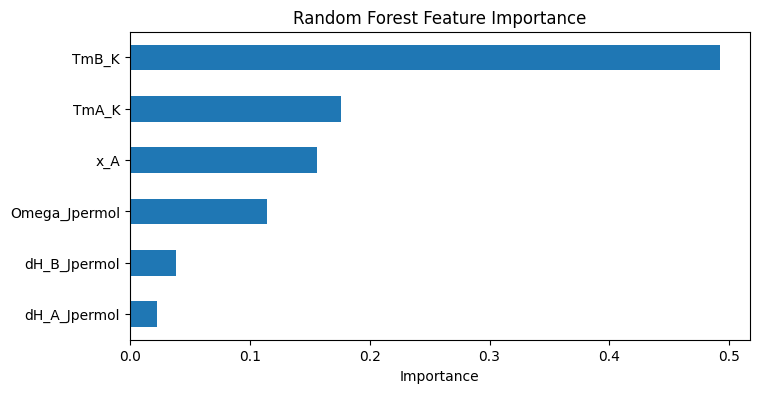

TmB_K            0.492489
TmA_K            0.175749
x_A              0.156420
Omega_Jpermol    0.114035
dH_B_Jpermol     0.038736
dH_A_Jpermol     0.022570
dtype: float64


In [ ]:
# UNIT 9: Feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8,4))
feat_imp.plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()
print(feat_imp.sort_values(ascending=False))


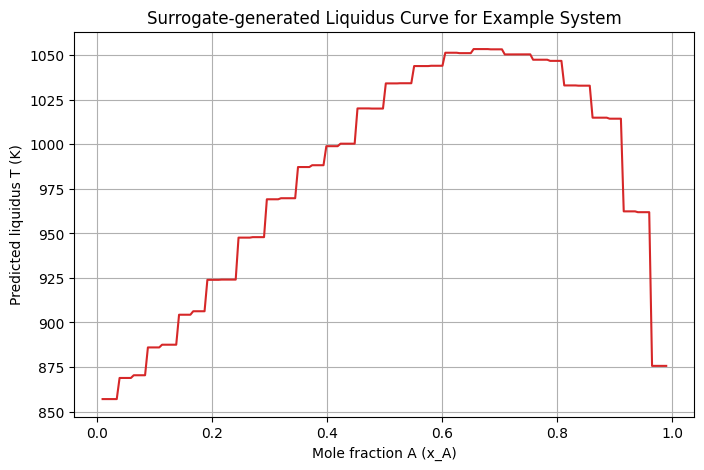

In [ ]:
# UNIT 10: Generate full phase diagram for a new system using surrogate
def generate_phase_diagram_from_surrogate(x_points, TmA, TmB, dH_A, dH_B, Omega, model):
    Xq = pd.DataFrame({
        "x_A": x_points,
        "TmA_K": [TmA]*len(x_points),
        "TmB_K": [TmB]*len(x_points),
        "dH_A_Jpermol": [dH_A]*len(x_points),
        "dH_B_Jpermol": [dH_B]*len(x_points),
        "Omega_Jpermol": [Omega]*len(x_points)
    })
    Tpred = model.predict(Xq)
    return pd.DataFrame({"x_A": x_points, "T_liquidus_pred_K": Tpred})

# Example new system
example_params = {
    "TmA": 1500.0,
    "TmB": 1100.0,
    "dH_A": 120000.0,
    "dH_B": 90000.0,
    "Omega": 20000.0
}
xq = np.linspace(0.01,0.99,200)
pdia = generate_phase_diagram_from_surrogate(xq, example_params["TmA"], example_params["TmB"],
                                             example_params["dH_A"], example_params["dH_B"],
                                             example_params["Omega"], rf)

plt.figure(figsize=(8,5))
plt.plot(pdia['x_A'], pdia['T_liquidus_pred_K'], color='tab:red')
plt.xlabel("Mole fraction A (x_A)")
plt.ylabel("Predicted liquidus T (K)")
plt.title("Surrogate-generated Liquidus Curve for Example System")
plt.grid(True)
plt.show()


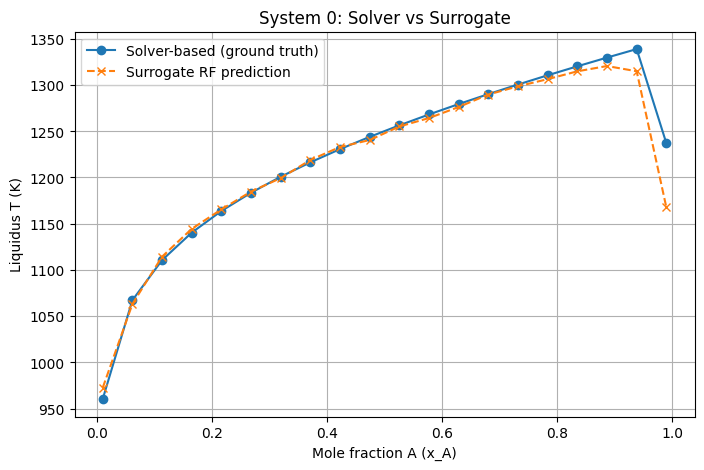

In [ ]:
# UNIT 11: Compare solver-based curve (computed earlier) vs surrogate for an existing generated system
test_sys = df_phase['system_id'].unique()[0]  # pick system 0 or change index
solved = df_phase[df_phase['system_id']==test_sys].sort_values('x_A')
x_s = solved['x_A'].values
# surrogate prediction using the same system parameters
TmA = solved['TmA_K'].iloc[0]
TmB = solved['TmB_K'].iloc[0]
dH_A = solved['dH_A_Jpermol'].iloc[0]
dH_B = solved['dH_B_Jpermol'].iloc[0]
Omega = solved['Omega_Jpermol'].iloc[0]

pred_df = generate_phase_diagram_from_surrogate(x_s, TmA, TmB, dH_A, dH_B, Omega, rf)

plt.figure(figsize=(8,5))
plt.plot(x_s, solved['T_liquidus_K'], 'o-', label='Solver-based (ground truth)')
plt.plot(pred_df['x_A'], pred_df['T_liquidus_pred_K'], 'x--', label='Surrogate RF prediction')
plt.xlabel("Mole fraction A (x_A)")
plt.ylabel("Liquidus T (K)")
plt.title(f"System {test_sys}: Solver vs Surrogate")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# UNIT 12: Save CSV and optionally export the trained model using joblib
df_phase.to_csv("phase_dataset_synthetic.csv", index=False)
print("Saved phase_dataset_synthetic.csv  (download from Colab files).")

# Save model
try:
    import joblib
    joblib.dump(rf, "surrogate_rf_phase.pkl")
    print("Saved surrogate_rf_phase.pkl")
except Exception as e:
    print("joblib not available or save error:", e)


Saved phase_dataset_synthetic.csv  (download from Colab files).
Saved surrogate_rf_phase.pkl


# AI-Driven Phase Diagram Generator
This notebook generates synthetic, physics-informed binary alloy phase-equilibrium data using a regular-solution van't Hoff style model, trains a Random Forest surrogate to predict liquidus temperatures, and visualizes phase diagrams. The dataset and surrogate model allow fast generation of many phase diagrams across widely varying thermodynamic parameters.

Files produced:
- phase_dataset_synthetic.csv  # synthetic dataset (~>20k rows)
- surrogate_rf_phase.pkl        # trained RandomForest surrogate model
